# Neural Network Model Analysis on House Prices

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels, device):
        self.features = features.to(device)
        self.labels = labels.to(device)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [26]:
# Load the data
X_train = pd.read_csv('./data/X_train.csv').values
y_train = pd.read_csv('./data/y_train.csv').values.squeeze()
X_test = pd.read_csv('./data/X_test.csv').values
y_test = pd.read_csv('./data/y_test.csv').values.squeeze()

# split train into train and validation
X_train_model_selection, X_val, y_train_model_selection, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4244997347)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

X_train_model_selection_tensor = torch.tensor(X_train_model_selection, dtype=torch.float32)
y_train_model_selection_tensor = torch.tensor(y_train_model_selection, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)


# Create custom datasets
train_dataset = CustomDataset(X_train_tensor, y_train_tensor, device)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor, device)
train_model_selection_dataset = CustomDataset(X_train_model_selection_tensor, y_train_model_selection_tensor, device)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor, device)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)
train_model_selection_loader = DataLoader(dataset=train_model_selection_dataset, batch_size=len(train_model_selection_dataset), shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=len(val_dataset), shuffle=False)

In [27]:
def forward_block(input_dim, output_dim, leaky_param=0.0, dropout_p=0.0, final_layer=False):
    if final_layer is False:
        return nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(leaky_param,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(input_dim, output_dim)
        )


# Neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_dim, layers, leaky_param, dropout_p):
        super(NeuralNet, self).__init__()
        self.first_layer = forward_block(input_dim, layers[0], leaky_param = leaky_param, dropout_p = dropout_p)
        self.num_layers = len(layers)
        self.middle_layers = []
        for i in range(self.num_layers - 1):
            self.middle_layers.append(
                forward_block(layers[i], layers[i+1], leaky_param = leaky_param, dropout_p = dropout_p).to(device)
            )
        self.last_layer = forward_block(layers[-1], 1, leaky_param = leaky_param, dropout_p = dropout_p, final_layer=True)
    
    def forward(self, x):
        outputs = self.first_layer(x)
        for i in range(self.num_layers - 1):
            outputs = self.middle_layers[i](outputs)
        outputs=self.last_layer(outputs)
        return outputs

In [28]:
# Function to compute RMSE
def rmse(loader, model):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, labels in loader:
            outputs = model(features)
            loss = criterion(outputs, labels).item()
            total_loss += loss * features.size(0)
    return np.sqrt(total_loss / len(loader.dataset))

# Training loop
def train(model, train_loader, criterion, optimizer, epochs, plot = True, verbose = True):
    model.train()
    epoch_count = []
    train_rmse = []
    test_rmse = []
    for epoch in range(epochs):
        for i, (features, labels) in enumerate(train_loader):
            # clear gradient
            optimizer.zero_grad()
            # calculate loss
            outputs = model(features)
            loss = criterion(outputs, labels)
            # back propagation
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 10 == 0 and verbose:
            print(f'Epoch [{epoch+1}/{epochs}], Train RMSE: {np.sqrt(loss.item()):.4f}')
        if (epoch+1) % 500 == 0:
            if verbose:
                print(f'Test RMSE: {rmse(test_loader, model)}')
            epoch_count.append(epoch)
            train_rmse.append(np.sqrt(loss.item()))
            test_rmse.append(rmse(test_loader, model))
    # Visualize loss history
    if plot:
        plt.plot(epoch_count, train_rmse, 'r--')
        plt.plot(epoch_count, test_rmse, 'b-')
        plt.legend(['Training Loss', 'Test Loss'])
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.show();

# Grid Search for best hyperparameters

In [30]:
param_grid = {
    'l2penalty': [0.001, 0.0015, 0.002],
    'dropout_p': [0.0, 0.1, 0.2]
}

val_rmse = []
param_pairs = []
for l2penalty in param_grid['l2penalty']:
    for dropout in param_grid['dropout_p']:
        print(f"Fitting NN with l2penalty = {l2penalty} and dropout_p = {dropout}")
        model = NeuralNet(input_dim = len(X_train_model_selection[0]), layers = [2048,1024,512,512,512], leaky_param = 0.10, dropout_p = dropout).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = l2penalty)
        criterion = nn.MSELoss()
        train(model, tqdm(train_model_selection_loader), criterion, optimizer, 2000, plot = False, verbose = False)
        val_rmse.append(rmse(val_loader, model))
        param_pairs.append([l2penalty, dropout])

Fitting NN with l2penalty = 0.001 and dropout_p = 0.0


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


Fitting NN with l2penalty = 0.001 and dropout_p = 0.1


100%|██████████| 1/1 [00:00<00:00, 13.47it/s]


Fitting NN with l2penalty = 0.001 and dropout_p = 0.2


100%|██████████| 1/1 [00:00<00:00, 14.00it/s]


Fitting NN with l2penalty = 0.0015 and dropout_p = 0.0


100%|██████████| 1/1 [00:00<00:00, 16.55it/s]


Fitting NN with l2penalty = 0.0015 and dropout_p = 0.1


100%|██████████| 1/1 [00:00<00:00, 14.54it/s]


Fitting NN with l2penalty = 0.0015 and dropout_p = 0.2


100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


Fitting NN with l2penalty = 0.002 and dropout_p = 0.0


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


Fitting NN with l2penalty = 0.002 and dropout_p = 0.1


100%|██████████| 1/1 [00:00<00:00, 15.21it/s]


Fitting NN with l2penalty = 0.002 and dropout_p = 0.2


100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [37]:
best_param_pairs = param_pairs[val_rmse.index(min(val_rmse))]
print("The best RMSE after grid search: ", min(val_rmse))
print(f"The best model have the following parameters: l2penalty = {best_param_pairs[0]}, dropout_p = {best_param_pairs[1]}")

The best RMSE after grid search:  64343.5200777825
The best model have the following parameters: l2penalty = 0.0015, dropout_p = 0.2


100%|██████████| 1/1 [00:00<00:00, 11.14it/s]


Epoch [10/6500], Train RMSE: 197950.7274
Epoch [20/6500], Train RMSE: 197937.6393
Epoch [30/6500], Train RMSE: 197908.6561
Epoch [40/6500], Train RMSE: 197858.4299
Epoch [50/6500], Train RMSE: 197786.1782
Epoch [60/6500], Train RMSE: 197681.1131
Epoch [70/6500], Train RMSE: 197554.5029
Epoch [80/6500], Train RMSE: 197394.6243
Epoch [90/6500], Train RMSE: 197208.9046
Epoch [100/6500], Train RMSE: 196980.7196
Epoch [110/6500], Train RMSE: 196721.3527
Epoch [120/6500], Train RMSE: 196425.7280
Epoch [130/6500], Train RMSE: 196098.2036
Epoch [140/6500], Train RMSE: 195754.9724
Epoch [150/6500], Train RMSE: 195374.8725
Epoch [160/6500], Train RMSE: 195018.6489
Epoch [170/6500], Train RMSE: 194523.2070
Epoch [180/6500], Train RMSE: 194025.3390
Epoch [190/6500], Train RMSE: 193504.3043
Epoch [200/6500], Train RMSE: 193024.6366
Epoch [210/6500], Train RMSE: 192366.7857
Epoch [220/6500], Train RMSE: 191813.6162
Epoch [230/6500], Train RMSE: 191228.8621
Epoch [240/6500], Train RMSE: 190602.7667
E

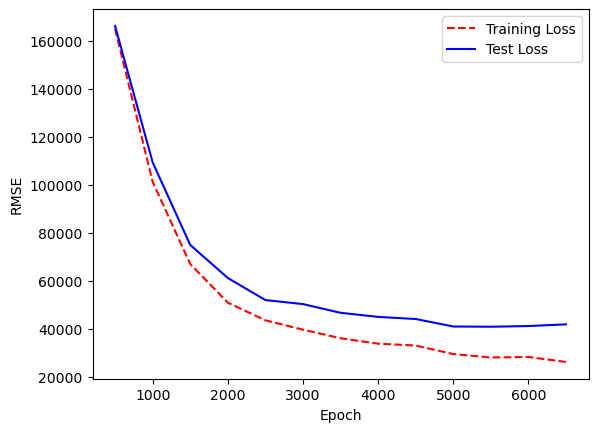

Test RMSE: 39653.1215416895


In [38]:
# parameters
num_epochs=6500
layer_archt=[2048,1024,512,512,512]
lr = 0.01
l2penalty = 0.0015
leaky_param=0.10
dropout_p=0.2

model = NeuralNet(input_dim = len(X_train[0]), layers = layer_archt, leaky_param = leaky_param, dropout_p = dropout_p).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = l2penalty)
criterion = nn.MSELoss()

train(model, tqdm(train_loader), criterion, optimizer, num_epochs)
test_rmse = rmse(test_loader, model)
print(f'Test RMSE: {test_rmse}')

# Train final model with tuned parameters

In [8]:
# parameters
num_epochs=6500
layer_archt=[2048,1024,512,512,512]
lr = 0.01
l2penalty = 0.0015
leaky_param=0.10
dropout_p=0.00

In [9]:
model = NeuralNet(input_dim = len(X_train[0]), layers = layer_archt, leaky_param = leaky_param, dropout_p = dropout_p).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = l2penalty)
criterion = nn.MSELoss()

100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


Epoch [10/6500], Train RMSE: 197951.0585
Epoch [20/6500], Train RMSE: 197940.0294
Epoch [30/6500], Train RMSE: 197915.6617
Epoch [40/6500], Train RMSE: 197873.6554
Epoch [50/6500], Train RMSE: 197810.4790
Epoch [60/6500], Train RMSE: 197723.3157
Epoch [70/6500], Train RMSE: 197610.2890
Epoch [80/6500], Train RMSE: 197470.1202
Epoch [90/6500], Train RMSE: 197302.0354
Epoch [100/6500], Train RMSE: 197105.4956
Epoch [110/6500], Train RMSE: 196880.1554
Epoch [120/6500], Train RMSE: 196625.7596
Epoch [130/6500], Train RMSE: 196342.5082
Epoch [140/6500], Train RMSE: 196030.5687
Epoch [150/6500], Train RMSE: 195690.0446
Epoch [160/6500], Train RMSE: 195321.1742
Epoch [170/6500], Train RMSE: 194924.2380
Epoch [180/6500], Train RMSE: 194499.4643
Epoch [190/6500], Train RMSE: 194047.1240
Epoch [200/6500], Train RMSE: 193567.5001
Epoch [210/6500], Train RMSE: 193060.9302
Epoch [220/6500], Train RMSE: 192527.7121
Epoch [230/6500], Train RMSE: 191968.1360
Epoch [240/6500], Train RMSE: 191382.5485
E

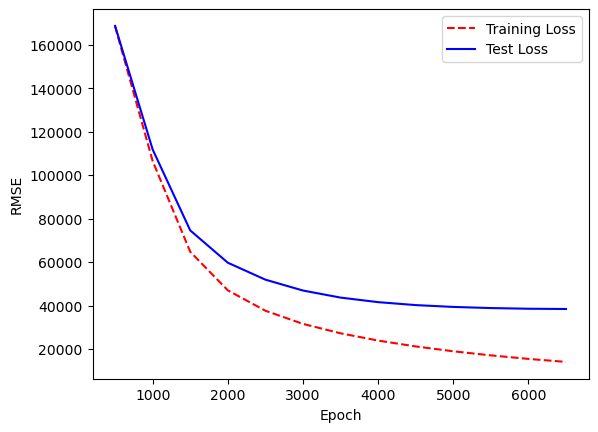

In [10]:
train(model, tqdm(train_loader), criterion, optimizer, num_epochs)

In [11]:
test_rmse = rmse(test_loader, model)
print(f'Test RMSE: {test_rmse}')

Test RMSE: 38393.93952175265
